In [85]:
import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

In [86]:
ft_epochs = torch.arange(4, 100, 5)
abs_distances_pre: torch.Tensor = torch.load('./trained_models/distances_solid_absolute_pre.pt', map_location='cpu')
abs_distances_ft: torch.Tensor = [
    torch.load(f'./trained_models/distances_solid_absolute_{i}.pt', map_location='cpu')
    for i in ft_epochs
]
abs_distances_pre.size()
ft_epochs

tensor([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89,
        94, 99])

In [87]:
torch.min(abs_distances_pre)

tensor(3.9399e-05)

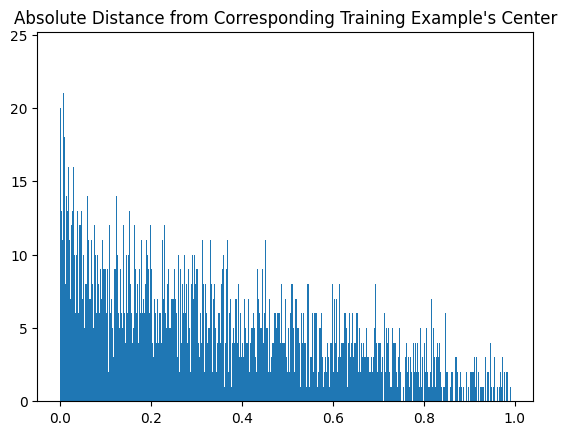

In [88]:
plt.hist(abs_distances_pre, bins=1000)
plt.title("Absolute Distance from Corresponding Training Example's Center")
plt.show()

In [89]:
abs_distances_pre = abs_distances_pre[abs_distances_pre < 0.01]
abs_distances_pre.size()

torch.Size([163])

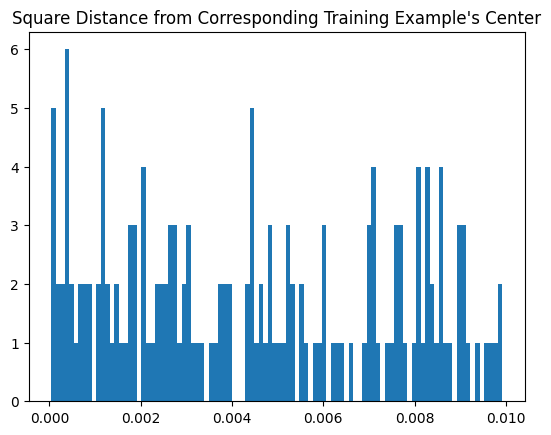

In [90]:
plt.hist(abs_distances_pre, bins=100)
plt.title("Square Distance from Corresponding Training Example's Center")
plt.show()

In [91]:
ft_epochs = torch.cat((torch.tensor([0]), ft_epochs))
abs_distances_ft = [abs_distances_pre] + abs_distances_ft
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_{epoch}_0.001.pt', map_location='cpu') for epoch in ft_epochs])

In [92]:
distance_buckets = [0.01, 0.001, 0.0001]
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]

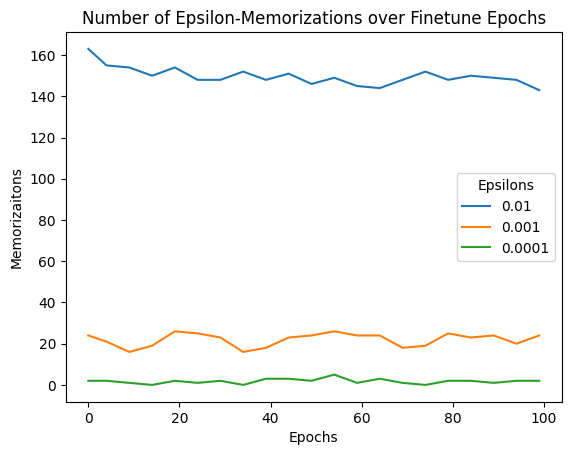

In [93]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket)
plt.legend(title="Epsilons")
plt.title("Number of Epsilon-Memorizations over Finetune Epochs")
plt.xlabel("Epochs")
plt.ylabel("Memorizaitons")
plt.show()

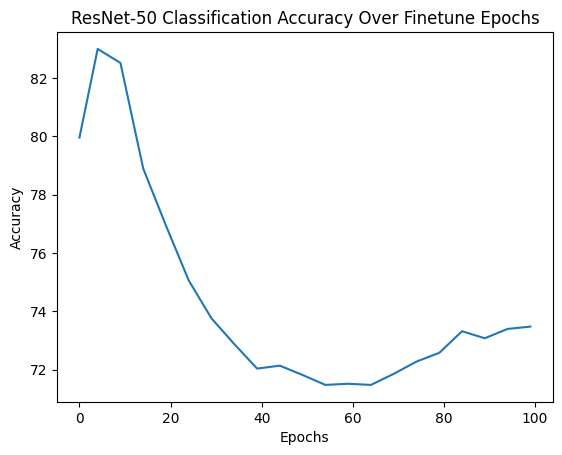

In [94]:
plt.plot(ft_epochs, accuracies)
plt.title("ResNet-50 Classification Accuracy Over Finetune Epochs")
plt.ylabel('Accuracy')
plt.xlabel("Epochs")
plt.show() 

In [96]:
ft_epochs = torch.arange(2, 22, 2)
mnist_epoch: int = 49 # MNIST Epoch - 1, so zero would be one epoch of FT
baseline_distances: torch.Tensor = abs_distances_pre
baseline_accuracy = accuracies[0]
abs_distances_ft: torch.Tensor = [
    torch.load(f'./trained_models/distances_solid_absolute_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu')
    for epoch in ft_epochs
]
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu') for epoch in ft_epochs])
abs_distances_pre.size()
ft_epochs

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [97]:
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]
baseline_buckets = [sum(baseline_distances < bucket) for bucket in distance_buckets]

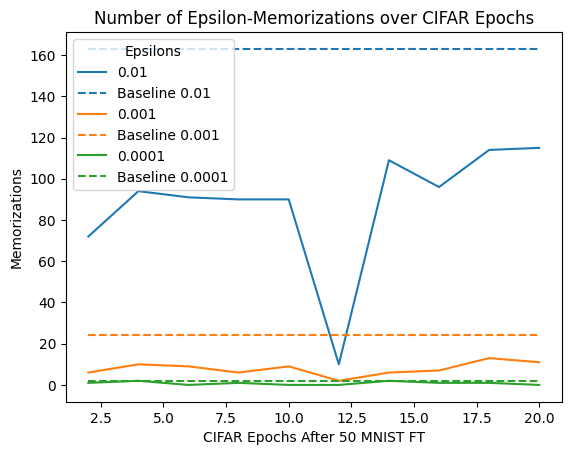

In [98]:
ax: Axes = plt.gca()
for i, bucket in enumerate(distance_buckets):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket, color=color)
    plt.plot(ft_epochs, [baseline_buckets[i] for _ in ft_epochs], '--', label=f"Baseline {bucket}", color=color)
plt.legend(title="Epsilons")
plt.title("Number of Epsilon-Memorizations over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Memorizations")
plt.show()

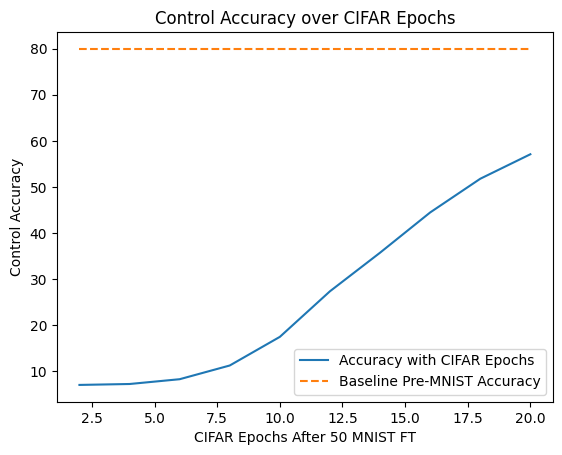

In [99]:
plt.plot(ft_epochs, accuracies, label="Accuracy with CIFAR Epochs")
plt.plot(ft_epochs, [baseline_accuracy for _ in ft_epochs], '--', label="Baseline Pre-MNIST Accuracy")
plt.title("Control Accuracy over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Control Accuracy")
plt.legend()
plt.show()

In [100]:
mnist_epochs = torch.arange(0, 50)
mnist_accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_epoch_{epoch}.pt', map_location='cpu') for epoch in mnist_epochs])

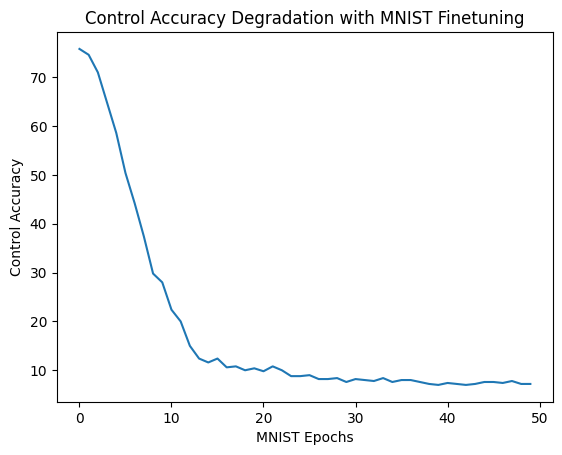

In [101]:
plt.plot(mnist_epochs, mnist_accuracies)
plt.xlabel("MNIST Epochs")
plt.ylabel("Control Accuracy")
plt.title("Control Accuracy Degradation with MNIST Finetuning")
plt.show()